# MRI Skull Stripping Baseline Models
This jupyter notebook includes all the experiments performed on a baseline models including linear models like random forest, decision tree and etc.

In [1]:
#import everything
import pydicom
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

### This is a regular image that needs to strip the skull

/home/keplerc/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  import sys


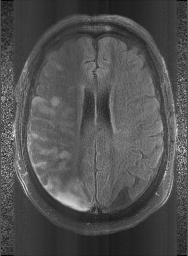

In [2]:
#a regular image file should look like this
from scipy.misc import toimage
train_file = "./data/IM-1081-0017.dcm"
ground_truth_file = "./data/BM-1081-0017.dcm"
input_file = pydicom.read_file(train_file)
image = preprocessing.scale(input_file.pixel_array)
toimage(image)

### A ground truth file as a bitmap

/usr/lib/python3/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  after removing the cwd from sys.path.


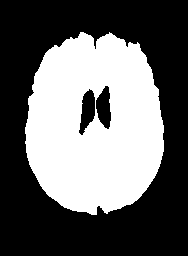

In [3]:
#loading a sample ground truth file
ground_truth = pydicom.read_file(ground_truth_file)
gt = ground_truth.pixel_array
toimage(gt)

In [4]:
# Hyperparameters 
m = 3 #the size of local patch

In [5]:
# a function that prepares training data for a single image
# it takes into acccount 
def prepare_training_data_for_an_image(image, gt):
    training_data = []
    training_label = []

    #prepare training
    for x in range(m, image.shape[0] - m):
        for y in range(m, image.shape[1] - m):
            #feature selection: 
            # *color
            # *px
            # *py
            training_data_for_pixel = [image[x][y], x, y] 
            # patch
            for px in range(x - m, x + m + 1):
                for py in range(y - m, y + m + 1):
                    training_data_for_pixel.append(image[px][py])
            training_label += [0 if gt[x][y] < 0.5 else 1]
            training_data.append(training_data_for_pixel)
    return training_data, training_label


In [6]:
import os 

#loading the rest images in data folder
training_data = []
training_label = []

counter = 0
#iterate through all files 
for path in os.listdir("./data/"):
    filename = ""
    if(path.startswith("IM")):
        filename = path
        counter += 1
        if counter > 4:
            continue
    else:
        continue
    
    #for each file, read in pixel and ground truth 
    input_file = pydicom.read_file("./data/" + path)
    image = preprocessing.scale(input_file.pixel_array)
    path = "B" + path[1:]
    ground_truth = pydicom.read_file("./data/" + path)
    print(path)
    gt = ground_truth.pixel_array
    
    d, l = prepare_training_data_for_an_image(image, gt)
    training_data += d
    training_label += l

/home/keplerc/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


BM-7903-0017.dcm
BM-8941-0016.dcm
BM-6938-0018.dcm
BM-7903-0019.dcm


In [7]:
from sklearn.linear_model import LogisticRegression
my_classifier = RandomForestClassifier()
my_classifier.fit(training_data, training_label)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [8]:
pred = my_classifier.predict(training_data)
accuracy_score(training_label, pred)

0.9990137614678899

In [9]:
#prediction
image = preprocessing.scale(input_file.pixel_array)
stripped_image = image
proc = []
for x in range(m, stripped_image.shape[0] - m):
    for y in range(m, stripped_image.shape[1] - m):
        l = [image[x][y], x, y]
        for px in range(x - m, x + m + 1):
            for py in range(y - m, y + m + 1):
                l.append(stripped_image[px][py])
        proc.append(l)
pred = my_classifier.predict(training_data)

counter = 0
for x in range(stripped_image.shape[0]):
    for y in range(stripped_image.shape[1]):
        if(x < m or y < m or x > stripped_image.shape[0] - m - 1 or y > stripped_image.shape[1] - m -1):
            stripped_image[x][y] = 0
        else:
            if(gt[x][y] <  1):
                stripped_image[x][y] = 0
            #if pred[counter] == 0:
            #    stripped_image[x][y] = 0 
            counter += 1


/home/keplerc/.local/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype uint16 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `toimage` is deprecated!
`toimage` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use Pillow's ``Image.fromarray`` directly instead.
  """Entry point for launching an IPython kernel.


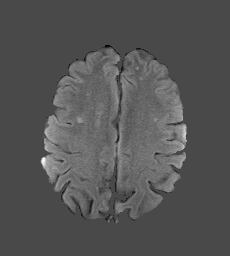

In [10]:
toimage(stripped_image)

In [11]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
import matplotlib.pyplot as plt
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

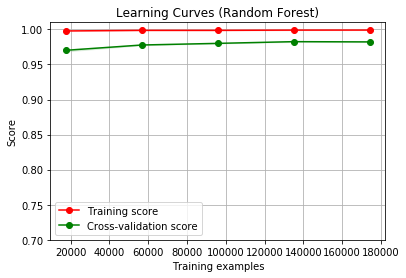

In [12]:
title = "Learning Curves (Random Forest)"
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
estimator = RandomForestClassifier()
plot_learning_curve(estimator, title, training_data, training_label, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

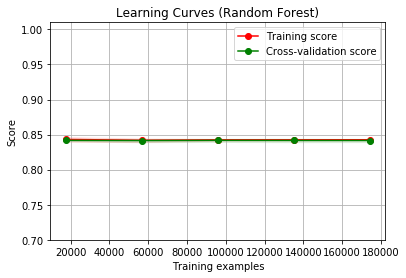

In [13]:
title = "Learning Curves (Logistic Regression)"
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
estimator = LogisticRegression()
plot_learning_curve(estimator, title, training_data, training_label, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()

In [ ]:
title = "Learning Curves (SVM)"
from sklearn.svm import SVC
cv = ShuffleSplit(n_splits=3, test_size=0.2, random_state=0)
estimator = SVC()
plot_learning_curve(estimator, title, training_data, training_label, ylim=(0.7, 1.01), cv=cv, n_jobs=4)
plt.show()